In [10]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import math
import matplotlib.pyplot as plt


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                             (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)


class SequenceVectorTransformer(nn.Module):
    def __init__(self, m, d_model, nhead, num_layers, dim_feedforward, dropout=0.1):
        super(SequenceVectorTransformer, self).__init__()
        self.input_fc = nn.Linear(m, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_fc = nn.Linear(d_model, m)

    def forward(self, x):
        x = self.input_fc(x)
        x = self.pos_encoder(x)
        x = x.permute(1, 0, 2)
        out = self.transformer_encoder(x)
        last = out[-1]
        return self.output_fc(last)


class LinearSequenceDataset(Dataset):
    def __init__(self, num_sequences, seq_len, m):
        starts = torch.randn(num_sequences, m)
        slopes = torch.randn(num_sequences, m)
        t = torch.arange(seq_len + 1, dtype=torch.float).unsqueeze(0).unsqueeze(2)
        seqs = starts.unsqueeze(1) + slopes.unsqueeze(1) * t
        self.inputs = seqs[:, :seq_len, :]
        self.targets = seqs[:, seq_len, :]

    def __len__(self):
        return self.inputs.size(0)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]


# Hyperparameters
m = 1
seq_len = 10
d_model = 32
nhead = 4
num_layers = 2
dim_feedforward = 64
batch_size = 64
epochs = 250
lr = 1e-3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Datasets
train_dataset = LinearSequenceDataset(500, seq_len, m)
test_dataset = LinearSequenceDataset(100, seq_len, m)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

# Model
model = SequenceVectorTransformer(m, d_model, nhead, num_layers, dim_feedforward).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

# Training
for epoch in range(1, epochs + 1):
    model.train()
    total = 0
    for seqs, targets in train_loader:
        seqs, targets = seqs.to(device), targets.to(device)
        optimizer.zero_grad()
        preds = model(seqs)
        loss = criterion(preds, targets)
        loss.backward()
        optimizer.step()
        total += loss.item()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{epochs}, Loss: {total/len(train_loader):.4f}")




Epoch 10/250, Loss: 39.8370
Epoch 20/250, Loss: 23.1003
Epoch 30/250, Loss: 13.4274
Epoch 40/250, Loss: 8.0521
Epoch 50/250, Loss: 5.4457
Epoch 60/250, Loss: 3.8595
Epoch 70/250, Loss: 3.1683
Epoch 80/250, Loss: 2.5026
Epoch 90/250, Loss: 2.0851
Epoch 100/250, Loss: 1.7036
Epoch 110/250, Loss: 1.5041
Epoch 120/250, Loss: 1.2177
Epoch 130/250, Loss: 1.3292
Epoch 140/250, Loss: 0.9978
Epoch 150/250, Loss: 0.8515
Epoch 160/250, Loss: 0.7801
Epoch 170/250, Loss: 0.8015
Epoch 180/250, Loss: 0.6879
Epoch 190/250, Loss: 0.7074
Epoch 200/250, Loss: 0.7661
Epoch 210/250, Loss: 0.6300
Epoch 220/250, Loss: 0.6774
Epoch 230/250, Loss: 0.6419
Epoch 240/250, Loss: 0.6204
Epoch 250/250, Loss: 0.5236


ValueError: not enough values to unpack (expected 3, got 2)

IndexError: index 1 is out of bounds for axis 2 with size 1

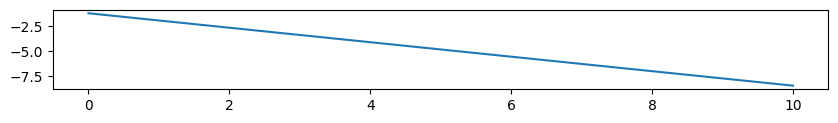

In [12]:
import matplotlib.pyplot as plt

with torch.no_grad():
    # grab a single batch of (inputs, targets)
    seqs, targets = next(iter(test_loader))        # seqs: (B, seq_len, m), targets: (B, m)
    # rebuild the full sequence: append target as the (seq_len+1)-th step
    full = torch.cat([seqs, targets.unsqueeze(1)], dim=1).cpu().numpy()  
    # full.shape == (B, seq_len+1, m)

# Plot evolution of two components for first 5 sequences
num_plot = 5
time = list(range(seq_len + 1))

plt.figure(figsize=(10, 6))
for i in range(num_plot):
    plt.subplot(num_plot, 1, i+1)
    plt.plot(time, full[i, :, 0], label='Component 0')
    plt.plot(time, full[i, :, 1], label='Component 1')
    plt.ylabel(f'Seq {i}')
    if i == 0:
        plt.legend(loc='upper left')

plt.xlabel('Time step')
plt.suptitle('Evolution of Two Components over Time')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
